In [1]:
from imports import *

**load data**

In [2]:
# Leer el archivo Parquet
table_loaded = pq.read_table("6'.parquet")

# Convertir de vuelta a Awkward Array o NumPy
input = ak.to_numpy(table_loaded["input"])
nuvT_c = ak.to_numpy(table_loaded["nuvT_c"])

print("Loaded matrix shape:", input.shape)  # Debería ser (21900, 400, 4)
print("Loaded vector shape:",nuvT_c.shape)  # Debería ser (21900,))
print("Matrix sample:\n", input[0, :3])
print("Vector sample:", nuvT_c[:3])

Loaded matrix shape: (21964, 400, 4)
Loaded vector shape: (21964,)
Matrix sample:
 [[1478.72460015   70.            0.            0.        ]
 [1480.72460015   16.            0.            0.        ]
 [1480.72460015   14.            0.            0.        ]]
Vector sample: [1462.42688725 1480.24647869  643.02543649]


In [3]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(input, nuvT_c, test_size=0.2, random_state=42)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer

class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Mask is True where we want to KEEP the data (not -1000 in all features)
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

# Define the model with functional API
inputs = Input(shape=(400, 4))
masked_inputs, mask = MaskNegative1000()(inputs)
lstm_out = LSTM(256, return_sequences=False)(masked_inputs, mask=mask)
x = Dense(32, activation='relu')(lstm_out)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model4 = Model(inputs, outputs)
model4.compile(optimizer='adam', loss='mse', metrics=['mae'])
model4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 400, 4)]     0           []                               
                                                                                                  
 mask_negative1000_6 (MaskNegat  ((None, 400, 4),    0           ['input_7[0][0]']                
 ive1000)                        (None, 400))                                                     
                                                                                                  
 lstm_7 (LSTM)                  (None, 256)          267264      ['mask_negative1000_6[0][0]',    
                                                                  'mask_negative1000_6[0][1]']    
                                                                                            

Epoch 1/40
550/550 [==============================] - 18s 25ms/step - loss: 353131.1250 - mae: 448.2536 - val_loss: 58648.0312 - val_mae: 172.1714
Epoch 2/40
550/550 [==============================] - 13s 23ms/step - loss: 35899.4961 - mae: 136.9329 - val_loss: 14011.7246 - val_mae: 83.1851
Epoch 3/40
550/550 [==============================] - 13s 23ms/step - loss: 25108.0391 - mae: 116.1346 - val_loss: 10962.2197 - val_mae: 74.2592
Epoch 4/40
550/550 [==============================] - 13s 23ms/step - loss: 21315.9883 - mae: 107.1011 - val_loss: 7144.6372 - val_mae: 55.7417
Epoch 5/40
550/550 [==============================] - 13s 23ms/step - loss: 18036.3496 - mae: 96.8789 - val_loss: 6390.6562 - val_mae: 51.2736
Epoch 6/40
550/550 [==============================] - 13s 23ms/step - loss: 18010.3379 - mae: 95.8235 - val_loss: 6162.4316 - val_mae: 52.4533
Epoch 7/40
550/550 [==============================] - 13s 23ms/step - loss: 17610.5176 - mae: 93.0924 - val_loss: 7358.9478 - val_mae

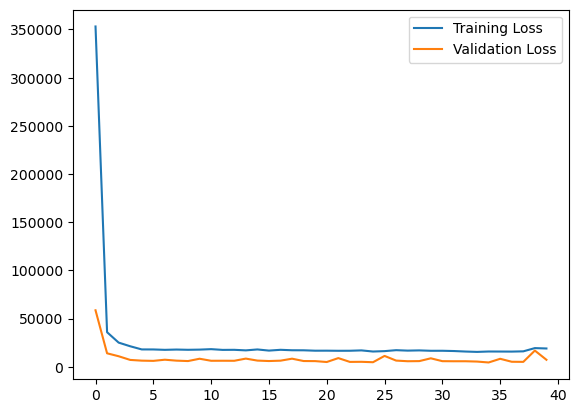

In [54]:
# Train the model
history = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,  # Adjust as needed
    batch_size=32,  # Adjust based on your memory
    verbose=1
)

# Plot training history (optional)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [55]:
# Evaluate on test set
test_loss, test_mae = model4.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions
predictions = model4.predict(X_test)
print("Sample predictions:", predictions[:5].flatten())
print("Sample true values:", y_test[:5])

Test Loss (MSE): 6739.0918, Test MAE: 60.6243
Sample predictions: [1449.7078   204.83289 1183.6631   556.2854  1183.4578 ]
Sample true values: [1368.17139222  246.55045488 1215.64841391  588.31544388 1253.36117219]


In [14]:
print(y_test)

[1368.17139222  246.55045488 1215.64841391 ...  929.52805127 1194.79245237
 1370.56543203]


In [36]:
print(ak.flatten(predictions)-y_test)

[-153, -74, 24.1, 3.37, -51.3, 15, ..., -183, -25.4, -107, 30.6, -123, -128]


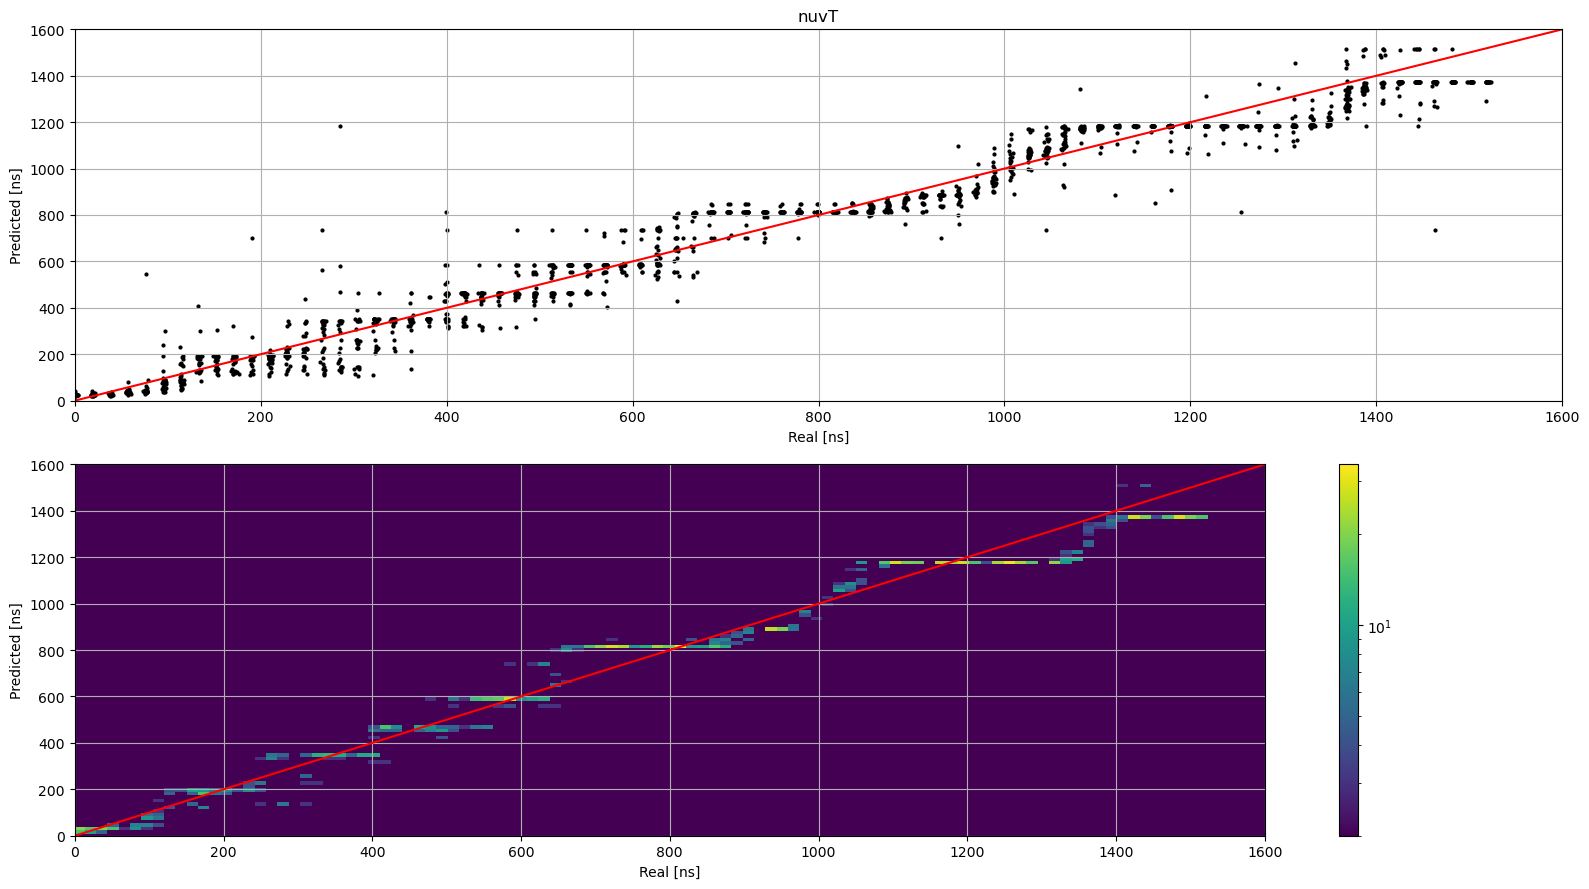

In [56]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,1,figsize=(16,9))

axs[0].scatter(y_test, predictions, color="black",s=4)
axs[0].grid()

axs[0].plot([0,1600],[0,1600],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1600])
axs[0].set_ylim([0,1600])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

im0 = axs[1].hist2d(y_test, predictions.flatten(), bins=(100, 100), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1600],[0,1600],'r')
axs[1].set_xlim([0,1600])
axs[1].set_ylim([0,1600])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')



fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

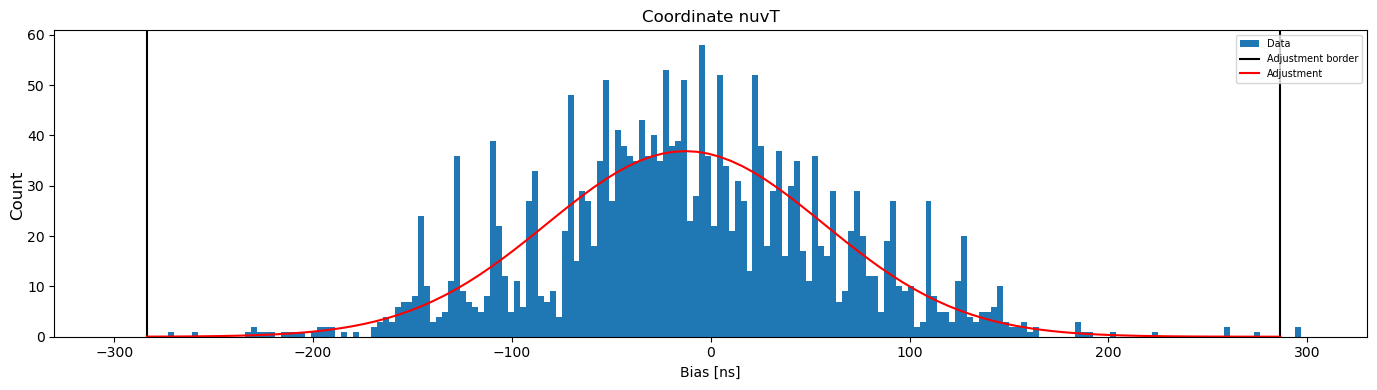

Bias Adjustment variables
------------------
Mean nuvT = -12.82
Sigma nuvT = 69.81
------------------


In [57]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = ak.flatten(predictions) - y_test

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, ax, coord_name, ini, fin, hist_range):
    counts, bins, patches = ax.hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    ax.axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    ax.axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    ax.plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    ax.set_xlabel('Bias [ns]')  # Set different xlabel for nuvT
    ax.set_title(f'Coordinate {coord_name}')
    ax.legend(prop={"size": 7})

    return popt

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(14, 4))

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, ax, 'nuvT', 5, 195, hist_range=[-300, 300])

# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
